In [1]:
# !jupyter nbconvert --to script ./print_model.ipynb

[NbConvertApp] Converting notebook ./print_model.ipynb to script
[NbConvertApp] Writing 336 bytes to ./print_model.py


In [3]:
import os
os.chdir('/workspace/my_cyclegan')

from options.train_options import TrainOptions
from dataloader import create_dataset
from models import create_model
from utils.visualizer import Visualizer

import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd

In [3]:
opt = TrainOptions().parse(isCodeCheck=True)
opt.name = 'pretrain_weights_instance'
opt.load_epoch = 'Nan'
opt.continue_train = True
opt.data_shuffle = True
opt.batch_size = 8
torch.cuda.set_device(opt.gpu_ids[0])

----------------- Options ---------------
               batch_size: 5                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
             data_shuffle: False                         
                 dataroot: /all_data/hdd/un_depth/semi/sample
             dataset_mode: semi_cycle                    
            deterministic: False                         
           disc_for_depth: False                         
         disc_for_normals: False                         
                  dropout: False                         
              epoch_count: 1                             
                 gan_mode: lsgan                         
                  gpu_ids: 0,1                           
                 img_freq: 1                             
                init_type:

In [4]:
dataset = create_dataset(opt)  
dataset_size = len(dataset)    # get the number of images in the dataset.
print('The number of training images = %d' % dataset_size)
vis = Visualizer(opt)

Dataset SemiCycleDataset was created
The number of training images = 20000


In [4]:
model = create_model(opt)      # create a model given opt.model and other options
model.setup()

initialize network with xavier
initialize network with xavier
model [PreTrainModel] was created
loading the model from ./checkpoints/pretrain_weights_instance/Nan.pt
loading the model from ./checkpoints/pretrain_weights_instance/Nan.pt
loading the optimizer from ./checkpoints/pretrain_weights_instance/Nan.pt
loading the optimizer from ./checkpoints/pretrain_weights_instance/Nan.pt
---------- Networks initialized -------------
[Network netG_A] Total number of parameters : 11.620 M
[Network netG_B] Total number of parameters : 11.620 M
-----------------------------------------------


In [9]:
device = torch.device('cuda:0')
criterionL1 = nn.L1Loss()

In [10]:
syn_rgb = torch.load('./checkpoints/pretrain_weights_instance/img_B.pt').to(device)
syn_depth = torch.load('./checkpoints/pretrain_weights_instance/depth_B.pt').to(device)
norm = model.surf_normals(syn_depth)

In [11]:
syn_rgb[5] = torch.rand((3,256,256))

In [12]:
syn_depth[5] = torch.rand((1,256,256))

In [13]:
fake_depth = model.netG_B(syn_depth, syn_rgb)
fake_norm = model.surf_normals(fake_depth)

In [19]:
inpt_d = torch.ones((1,1,256,256)) * 1
inpt_d = inpt_d.to(device)
inpt_r = torch.ones((1,3,256,256)) *  0.6549
fake_d = model.netG_B(inpt_d, inpt_r.to(device))
fake_n = model.surf_normals(fake_d)

In [20]:
loss = criterionL1(inpt_d, fake_d) #+  10 * criterionL1(norm, fake_norm)
loss.backward()

In [14]:
loss = criterionL1(syn_depth, fake_depth) #+  10 * criterionL1(norm, fake_norm)
loss.backward()

In [15]:
layer = []
for n, p in model.netG_B.module.named_parameters():
    layer.append(n)

In [16]:
param_stat = pd.DataFrame(index=layer, columns=['mean_w', 'max_w', 'min_w', 'mean_g', 'max_g', 'min_g'])

In [17]:
for n, p in model.netG_B.module.named_parameters():
    param_stat['mean_w'][n] = p.mean().item()
    param_stat['max_w'][n] = p.max().item()
    param_stat['min_w'][n] = p.min().item()
    
    param_stat['mean_g'][n] = p.grad.mean().item()
    param_stat['max_g'][n] = p.grad.max().item()
    param_stat['min_g'][n] = p.grad.min().item()

In [ ]:
model.netG_B.module

In [20]:
param_stat[:21]

,mean_w,max_w,min_w,mean_g,max_g,min_g
enc_img.model.0.weight,-0.00177555,0.201155,-0.173474,-3.73289e-05,0.000800824,-0.00103148
enc_img.model.1.weight,0.999768,1.0096,0.990852,-2.54118e-07,0.000285262,-0.000254513
enc_img.model.1.bias,-0.00351894,0.00354256,-0.00901579,-2.41883e-05,0.000207401,-0.000263856
enc_img.model.3.weight,0.0018301,0.203237,-0.210798,2.29939e-06,0.000340727,-0.000268511
enc_img.model.4.weight,0.999304,1.01329,0.984043,-5.85856e-08,0.000140873,-0.000106548
enc_img.model.4.bias,-0.000512854,0.00627173,-0.00820378,-1.8883e-05,0.000139586,-0.000144153
enc_img.model.6.weight,-0.000605691,0.173845,-0.161521,1.67918e-06,0.000378504,-0.000279367
enc_img.model.7.weight,0.982175,0.994498,0.969237,9.41587e-06,0.000301031,-0.000436693
enc_img.model.7.bias,-0.00958517,-0.000464395,-0.020035,3.26628e-06,0.000285334,-0.0002816
enc_depth.model.0.weight,0.00142345,0.155788,-0.183711,-0.0021527,0.00461226,-0.0169174


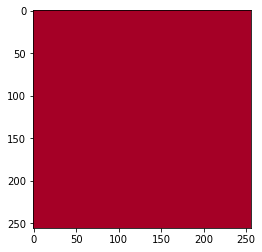

In [108]:
plt.imshow(syn_depth[5,0].cpu().data,cmap=plt.get_cmap('RdYlBu'))

In [109]:
torch.unique(syn_depth[5,0])

tensor([-1.], device='cuda:0')

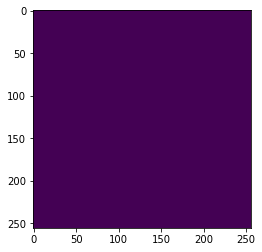

In [9]:
plt.imshow(syn_rgb[5,0].cpu())

In [12]:
torch.unique(syn_rgb[5,0])

tensor([0.6549], device='cuda:0')

In [124]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        model = [
            nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1, dilation=1, padding_mode='replicate', bias=False),
            nn.InstanceNorm2d(3, affine=True),
            nn.ReLU(True),
            nn.Conv2d(3, 1, kernel_size=3, stride=1, padding=1, dilation=1, padding_mode='replicate', bias=True),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)

In [125]:
net  = Net()
criterionL1 = nn.L1Loss()

In [126]:
from torch.nn import init
init_type='xavier'
init_gain='relu'
param=0.2
def init_func(m):  # define the initialization function
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        if init_type == 'normal':
            init.normal_(m.weight.data, mean=0.0, std=0.02)
        elif init_type == 'xavier':
            init.xavier_normal_(m.weight.data, gain=init.calculate_gain(init_gain, param))#
        elif init_type == 'kaiming':
            init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        elif init_type == 'orthogonal':
            init.orthogonal_(m.weight.data, gain=init.calculate_gain(init_gain, param))
        else:
            raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
        if hasattr(m, 'bias') and m.bias is not None:
            init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
        init.normal_(m.weight.data, mean=1.0, std=0.02)
        init.constant_(m.bias.data, 0.0)
    print('initialize network with %s' % init_type)
net.apply(init_func)  # apply the initialization function <init_func>

initialize network with xavier
initialize network with xavier
initialize network with xavier
initialize network with xavier
initialize network with xavier
initialize network with xavier
initialize network with xavier


Net(
  (model): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=replicate)
    (1): InstanceNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (4): Tanh()
  )
)

In [56]:
i1 = torch.ones((1,1,3,3))
i2 = torch.rand((1,1,3,3))
# input = torch.cat((i1,i2), dim=0)
input = i1

In [57]:
out = net(input)

NameError: name 'net' is not defined

In [129]:
out

tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]]], grad_fn=<TanhBackward>)

In [130]:
loss = criterionL1(out, input)

In [131]:
loss.backward()

In [132]:
net.model[1].weight

Parameter containing:
tensor([1., 1., 1.], requires_grad=True)

In [58]:
i1 = torch.ones((1,2,3,3), dtype=torch.float32, requires_grad=True)
i2 = torch.rand((1,2,3,3), dtype=torch.float32, requires_grad=True)
x = torch.cat((i1,i2), dim=0)
x.retain_grad()
gamma = torch.ones((2), dtype=torch.float32, requires_grad=True)
beta = torch.zeros((2), dtype=torch.float32, requires_grad=True)
gamma = gamma.unsqueeze(0).unsqueeze(2).unsqueeze(3)
beta = beta.unsqueeze(0).unsqueeze(2).unsqueeze(3)

In [59]:
x

tensor([[[[1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000]]],


        [[[0.5802, 0.8318, 0.2311],
          [0.8148, 0.7508, 0.8666],
          [0.8199, 0.8049, 0.8736]],

         [[0.3010, 0.7711, 0.0701],
          [0.5419, 0.8766, 0.8417],
          [0.1548, 0.3816, 0.9937]]]], grad_fn=<CatBackward>)

In [60]:
mean = torch.mean(x, dim=(2,3), keepdim=True)
mean.retain_grad()

In [61]:
mean.shape

torch.Size([2, 2, 1, 1])

In [62]:
sub = x - mean
sub.retain_grad()

sub1 = sub*1
sub1.retain_grad()
sub2 = sub*1
sub2.retain_grad()

In [63]:
powsub = torch.pow(sub2,2)
powsub.retain_grad()

In [64]:
var = torch.mean(powsub, dim=(2,3), keepdim=True)
var.retain_grad()

In [65]:
std = torch.sqrt(var + 1e-05)
std.retain_grad()

In [66]:
std1 = 1 / std
std1.retain_grad()

In [67]:
x_h = sub1 * std1
x_h.retain_grad()

In [68]:
out = x_h * gamma + beta

In [69]:
out

tensor([[[[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000]]],


        [[[-0.7700,  0.5198, -2.5600],
          [ 0.4329,  0.1045,  0.6980],
          [ 0.4590,  0.3818,  0.7340]],

         [[-0.7752,  0.6997, -1.4993],
          [-0.0193,  1.0306,  0.9212],
          [-1.2337, -0.5221,  1.3981]]]], grad_fn=<MulBackward0>)

In [70]:
grad =torch.rand((2,2,3,3))
out.backward(grad)

In [71]:
torch.allclose(x_h.grad, grad * gamma)

True

In [72]:
torch.allclose(sub1.grad, gamma*grad*std1)

True

In [73]:
torch.allclose(std1.grad, torch.sum(gamma*grad*sub1, dim=(2,3), keepdim=True))

True

In [74]:
torch.allclose(std.grad, -1/(var + 1e-05)*torch.sum(gamma*grad*sub1, dim=(2,3), keepdim=True))

True

In [75]:
torch.allclose(var.grad, -1/(var + 1e-05)*torch.sum(gamma*grad*sub1, dim=(2,3), keepdim=True)*0.5*1/(torch.sqrt(var + 1e-05)))

True

In [76]:
torch.allclose(powsub.grad, 1/(3*3)*(-1)/(var + 1e-05)*torch.sum(gamma*grad*sub1, dim=(2,3), keepdim=True)*0.5*1/(torch.sqrt(var + 1e-05)))

True

In [77]:
torch.allclose(sub2.grad, 2*sub2*1/(3*3)*(-1)/(var + 1e-05)*torch.sum(gamma*grad*sub1, dim=(2,3), keepdim=True)*0.5*1/(torch.sqrt(var + 1e-05)))

True

In [78]:
torch.allclose(sub.grad,gamma*grad*std1 + 2*sub2*1/(3*3)*(-1)/(var + 1e-05)*torch.sum(gamma*grad*sub1, dim=(2,3), keepdim=True)*0.5*1/(torch.sqrt(var + 1e-05)))

True

In [79]:
grad_sub = gamma*grad*std1 + 2*sub2*1/(3*3)*(-1)/(var + 1e-05)*torch.sum(gamma*grad*sub1, dim=(2,3), keepdim=True)*0.5*1/(torch.sqrt(var + 1e-05))

In [80]:
 gamma*grad*std1

tensor([[[[2.0060e+02, 2.5289e+02, 2.6611e+02],
          [8.9893e+01, 3.7512e+01, 1.2471e+02],
          [7.1248e+01, 8.2014e+01, 1.8256e+02]],

         [[2.9461e+01, 1.7910e+02, 1.3853e+02],
          [3.3659e+01, 2.3346e+02, 1.4518e+02],
          [1.6966e+02, 1.4767e+02, 2.5728e+01]]],


        [[[3.1451e-01, 2.0462e+00, 4.7184e+00],
          [1.9679e+00, 2.8213e+00, 8.7850e-01],
          [1.2349e+00, 1.9010e+00, 3.5137e+00]],

         [[2.7046e-02, 3.1078e+00, 1.0873e+00],
          [6.7400e-01, 3.7439e-01, 1.7099e+00],
          [1.7944e+00, 1.8242e+00, 6.6631e-01]]]], grad_fn=<MulBackward0>)

In [81]:
2*sub2*1/(3*3)*(-1)/(var + 1e-05)*torch.sum(gamma*grad*sub1, dim=(2,3), keepdim=True)*0.5*1/(torch.sqrt(var + 1e-05))

tensor([[[[-0.0000e+00, -0.0000e+00, -0.0000e+00],
          [-0.0000e+00, -0.0000e+00, -0.0000e+00],
          [-0.0000e+00, -0.0000e+00, -0.0000e+00]],

         [[-0.0000e+00, -0.0000e+00, -0.0000e+00],
          [-0.0000e+00, -0.0000e+00, -0.0000e+00],
          [-0.0000e+00, -0.0000e+00, -0.0000e+00]]],


        [[[-4.8136e-01,  3.2495e-01, -1.6003e+00],
          [ 2.7061e-01,  6.5298e-02,  4.3637e-01],
          [ 2.8696e-01,  2.3865e-01,  4.5885e-01]],

         [[ 2.0398e-02, -1.8411e-02,  3.9451e-02],
          [ 5.0798e-04, -2.7118e-02, -2.4239e-02],
          [ 3.2463e-02,  1.3737e-02, -3.6788e-02]]]], grad_fn=<DivBackward0>)

In [82]:
torch.allclose(mean.grad, -1* torch.sum(grad_sub, dim=(2,3), keepdim=True))

True

In [83]:
torch.allclose(x.grad,grad_sub -1* torch.sum(grad_sub, dim=(2,3), keepdim=True)* 1/(3*3))

True

In [84]:
x.grad

tensor([[[[ 5.5322e+01,  1.0761e+02,  1.2083e+02],
          [-5.5389e+01, -1.0777e+02, -2.0576e+01],
          [-7.4034e+01, -6.3269e+01,  3.7280e+01]],

         [[-9.3032e+01,  5.6606e+01,  1.6033e+01],
          [-8.8835e+01,  1.1097e+02,  2.2684e+01],
          [ 4.7167e+01,  2.5178e+01, -9.6765e+01]]],


        [[[-2.3220e+00,  2.1603e-01,  9.6290e-01],
          [ 8.3308e-02,  7.3148e-01, -8.4029e-01],
          [-6.3334e-01, -1.5467e-02,  1.8174e+00]],

         [[-1.2042e+00,  1.8377e+00, -1.2498e-01],
          [-5.7718e-01, -9.0442e-01,  4.3392e-01],
          [ 5.7517e-01,  5.8621e-01, -6.2217e-01]]]])

In [6]:
for data in dataset:
    model.set_input(data)
    model.optimize_param()
#     vis.plot_a2b(model.get_current_vis())
    break

In [13]:
model.get_current_losses()

OrderedDict([('D_A_depth', nan),
             ('D_B_depth', nan),
             ('G_A', nan),
             ('G_B', nan),
             ('cycle_A', 0.48907947540283203),
             ('cycle_B', 2.061032295227051),
             ('depth_range_A', 0.5395360589027405),
             ('depth_range_B', 1.2941814661026)])

In [25]:
model.netD_A_depth.module

NLayerDiscriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [30]:
for n, p in model.netD_A_depth.module.named_parameters():
    if torch.isnan(p).any():
        raise RuntimeError('Nan')

RuntimeError: Nan

In [37]:
for name, param in model.netD_A_depth.module.named_parameters():
    print(name, torch.isnan(param.grad).any())

model.0.weight tensor(True, device='cuda:0')
model.0.bias tensor(True, device='cuda:0')
model.2.weight tensor(True, device='cuda:0')
model.2.bias tensor(True, device='cuda:0')
model.5.weight tensor(True, device='cuda:0')
model.5.bias tensor(True, device='cuda:0')
model.8.weight tensor(True, device='cuda:0')
model.8.bias tensor(True, device='cuda:0')
model.11.weight tensor(True, device='cuda:0')
model.11.bias tensor(True, device='cuda:0')


In [5]:
data['A_semantic'].dtype

torch.int64

In [22]:
a = torch.tensor([True, False])

In [24]:
torch.sum(a)

tensor(1)

In [6]:
import imageio
import matplotlib.pyplot as plt

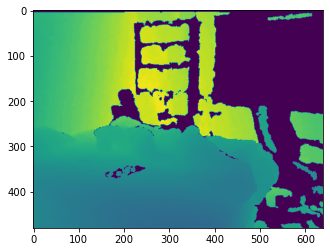

In [11]:
a = imageio.imread('/all_data/hdd/un_depth/semi/sample/testA/depth/scene0092_01_200.png')
plt.imshow(a)

In [1]:
import os
os.chdir('/workspace/my_cyclegan')

In [6]:
# !python train.py --dataroot /all_data/hdd/un_depth/semi/sample\
# --gpu_ids 1\
# --name test\
# --gan_mode vanilla\
# --use_blur\
# --netG resnet_6blocks\
# --ngf_depth 20\
# --ngf_rgb 32\
# --ngf_depth_edge 16\
# --ndf 64\
# --netD n_layers\
# --n_layers_D 3\
# --l_depth_large_A 70\
# --l_depth_small_A 70\
# --l_depth_large_B 10\
# --l_depth_small_B 10\
# --l_depth_max_iter 30000\
# --lambda_cycle_A 5.0\
# --lambda_identity 2.5\
# --lambda_reconstruction 0.0\
# --max_dataset_size 18\
# --batch_size 6\
# --load_size_h 480\
# --load_size_w 640\
# --lr_D 0.0003\
# --lr_G 0.0002\
# --num_iter_gen 3\
# --norm instance\
# --init_type xavier\
# --beta1 0.5\
# --img_freq 1\
# --loss_freq 1\
# --save_epoch_freq 10\
# --n_epochs 10\
# --n_epochs_decay 5\
# # --netG_d2e unet_256\
# # --net_d2e_weights './checkpoints/depth_edge_unet_1.5_weight_binatyloss/last_netG_B.pth'\